Note to users:<h6> Before running, change file path names as appropriate. </h6>

Throughout I reference code adapted from Peter Grenholm's model which can be found on Kaggle <a href="https://www.kaggle.com/toregil/mystery-planet-99-8-cnn">here</a>, along with the training and test datasets. The rest, which is not so referenced, is my own. His implementation is less compute-intensive, but this model below produces better results. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage.filters import uniform_filter1d

import keras
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding, Flatten, BatchNormalization
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D

import sklearn.metrics as skl
from sklearn.model_selection import train_test_split

import pickle as pkl
import math

%matplotlib inline

C:\Users\shark\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


First load the data:

In [2]:
exotrain = pd.read_csv('kepler-labelled-time-series-data\exoTrain.csv')
exotest = pd.read_csv('kepler-labelled-time-series-data\exoTest.csv')
print('Done loading the data.')

Done loading the data.


In [3]:
labels_train, labels_test = exotrain.LABEL-1, exotest.LABEL-1 #relabelling: yes_planet=1 and no_planet=0 instead of 2, 1 respectively
exotrain, exotest = exotrain.drop('LABEL',axis=1), exotest.drop('LABEL',axis=1)

In order to get general idea of the shape and features in the data, it is sensible to explore graphically a sample of stars with planets (hereinafter ‘positive examples’) and without planets (hereinafter ‘negative examples’).

In [4]:
first_np = labels_train.loc[labels_train==1].shape[0]
titles_p = []
titles_np = []
for starnum in range(8):
    titles_p.append('Star with planet {}'.format(starnum))
    titles_np.append('Star without planet {}'.format(starnum))

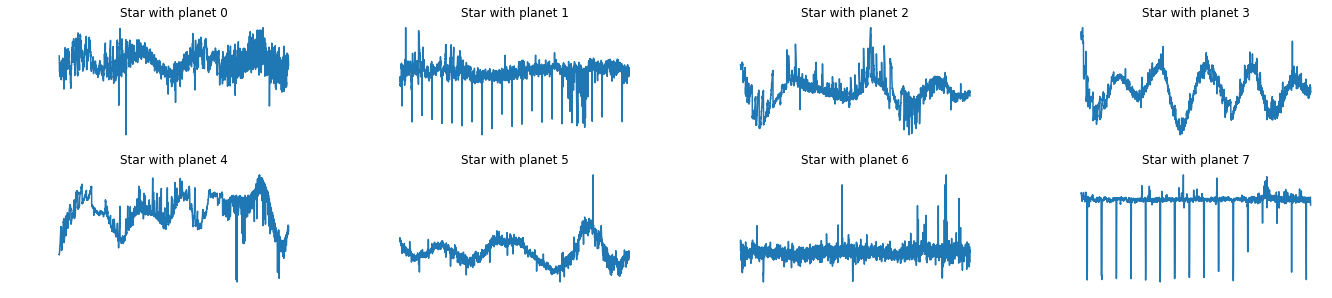

In [5]:
#plotting stars WITH planets
image_p = plt.figure()
for starnum in range(8):
    plt.subplot(2,4,starnum+1)
    plt.title(titles_p[starnum])
    plt.axis('off')
    exotrain.iloc[starnum,:].transpose().plot(legend = None)
    plt.grid(True)
plt.subplots_adjust(top=0.92, bottom=0, left=-2, right=0.95, hspace=0.25, wspace=0.35)
image_p.savefig('stars_with_planets.png', bbox_inches='tight')

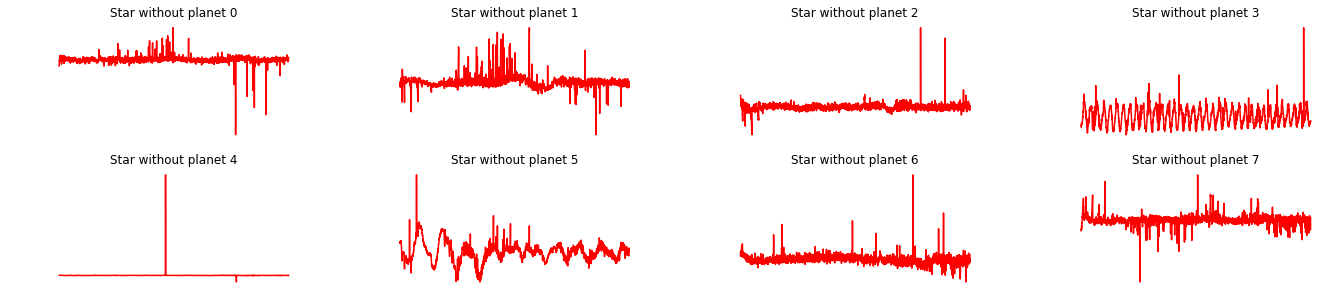

In [6]:
#plotting stars WITHOUT planets
image_np = plt.figure()
for starnum in range(8):
    plt.subplot(2,4,starnum+1)
    plt.title(titles_np[starnum])
    plt.axis('off')
    exotrain.iloc[first_np+starnum,:].transpose().plot(legend = None, color='r')
    plt.grid(True)
plt.subplots_adjust(top=0.92, bottom=0, left=-2, right=0.95, hspace=0.25, wspace=0.35)
image_np.savefig('stars_without_planets.png', bbox_inches='tight')

We apply normalisation to both the training and the test data, star by star. 

In [7]:
def normalize_rows(input_df):
    for index in range(input_df.shape[0]):
        input_df.iloc[index, :] = (input_df.iloc[index, :] - input_df.iloc[index, :].mean()) / input_df.iloc[index, :].std()
    return input_df

In [8]:
x_train, x_test, y_train, y_test = normalize_rows(exotrain), normalize_rows(exotest), labels_train, labels_test
print('normalisation complete.')

normalisation complete.


Now I double the size of the positive examples by reversing them in time and adding the reversed examples. 

In [9]:
positives = x_train.loc[y_train==1]
reversed_positives = positives[positives.columns[::-1]]
reversed_positives.columns = positives.columns

In [10]:
#Now we add them to the start and do the same for their labels and relabel
x_train = pd.concat([reversed_positives, x_train])
y_train = pd.concat([y_train.loc[y_train==1], y_train])

In [11]:
#We convert the dataframes to np arrays for ease of manipulation later
x_train = pd.DataFrame.as_matrix(x_train)
x_test = pd.DataFrame.as_matrix(x_test)
y_train = pd.DataFrame.as_matrix(y_train)
y_test = pd.DataFrame.as_matrix(y_test)

We'll get everything into the right shape before feeding it into the CNN. 

In [12]:
#we reshape the data for input to the CNN
y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)


Additionally, we add channels of varying smoothness. This is a very important step as it allows us the CNN to look at both the noisy data and smooth data, which has information over longer timescales than just the small kernels on the noisy data. 

Credit to Peter Grenholm on Kaggle for this step.

In [13]:
#Adding the smoothed timeseries as a second dimension.
x_train = np.stack([x_train, uniform_filter1d(x_train, axis=1, size=200)], axis=2)
x_test = np.stack([x_test, uniform_filter1d(x_test, axis=1, size=200)], axis=2)

<h1> The Convolutional Neural Net (CNN) </h1>



We need an approach to modelling that is (1) able to extract subtle planetary features (i.e. patterns that mark a star as having a planet); (2) able to distinguish these features from noise; (3) able to identify the regularity of these features; (4) scalable to a large number of examples; (5) insensitive to different periodicities of planetary features across examples; (6) insensitive to (or removes) macroscopic and microscopic noise, some of which itself may be regular. Additionally, there may be planetary features hidden in the data that are not obvious to humans, and it would be ideal if our model could employ these features too for classification. 

A CNN meets these specifications. 

Before we build the CNN and run the experiments, we'll define a few functions and variables that we'll use in the experiments. 

Here we build a batch generator (adapted from Peter Grenholm on Kaggle), since without custom-defining batches, default-random batches will consist almost entirely of negative examples and the signal for positive examples will be drowned out. An alternative might be adding an exceptionally large penalty for false negatives (for example, by labelling positive examples with 100 instead of 1). But this method is sufficient to yield good results. For further data augmentation, this function also rotates the examples in time. 

In [14]:
def batch_generator(x_train, y_train, batch_size=32):
    """
    Gives equal number of positive and negative samples, and rotates them randomly in time
    """
    half_batch = batch_size // 2
    x_batch = np.empty((batch_size, x_train.shape[1], x_train.shape[2]), dtype='float32')
    y_batch = np.empty((batch_size, y_train.shape[1]), dtype='float32')
    
    yes_idx = np.where(y_train[:,0] == 1.)[0]
    non_idx = np.where(y_train[:,0] == 0.)[0]
    while True:
        np.random.shuffle(yes_idx)
        np.random.shuffle(non_idx)
    
        x_batch[:half_batch] = x_train[yes_idx[:half_batch]]
        x_batch[half_batch:] = x_train[non_idx[half_batch:batch_size]]
        y_batch[:half_batch] = y_train[yes_idx[:half_batch]]
        y_batch[half_batch:] = y_train[non_idx[half_batch:batch_size]]
    
        for i in range(batch_size):
            sz = np.random.randint(x_batch.shape[1])
            x_batch[i] = np.roll(x_batch[i], sz, axis = 0)
     
        yield x_batch, y_batch

In the experiments for-loop, we will reset our model every time by rebuilding it, calling this function.  

Credit to Peter Grenholm for many features of the architecture. 

In [15]:
def build_model():
    
    model = Sequential()
    model.add(Conv1D(filters=10, kernel_size=11, activation='relu', input_shape=x_train.shape[1:]))
    model.add(MaxPooling1D(strides=4))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=20, kernel_size=11, activation='relu'))
    model.add(MaxPooling1D(strides=4))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=40, kernel_size=11, activation='relu'))
    model.add(MaxPooling1D(strides=4))
    model.add(BatchNormalization())
    model.add(Conv1D(filters=80, kernel_size=11, activation='relu'))
    model.add(MaxPooling1D(strides=4))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    return model


Instead of using the same learning rate for each epoch, we will half the learning rate every 10 epochs. 

In [16]:
def step_decay(epoch):
    initial_lrate = 0.05
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

Because our positive example are very few, it might be the case that taking out certain important examples for use in the validation set might affect learning. To test for this, I use a different validation set every experiment by running this function in the experiment for-loop: 

In [17]:
def validation_set_generator(x_train, y_train, test_size=0.10):  
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=test_size, shuffle=True, stratify=y_train)
    return (x_train, x_val, y_train, y_val)   

In [18]:
# Storing training sets in variables of different names. This step is just
# for convenience and can be skipped if memory is a constraint, but make sure
# to change the names of variables in later steps as appropriate.

x_train2, y_train2 = x_train, y_train

Finally, we'll define the batch size, the number of experiments, and some callbacks that will define the early-stopping and learning rate decay processes. 

In [19]:
#Initialise variables for the experiment
b_size = 32

#how many experiment we want to run
experiments = range(0, 10)

#Define our hyperparameters for early stopping and learning-rate decay
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=20, verbose=1, mode='min')   
lr_schedule = keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

<h3>Running the experiments</h3>

Time per experiment will vary.

Filepath names should be changed as appropriate. 

In [29]:
for experiment in experiments:
    print("Experiment #{}".format(experiment))
    model = build_model()
    model.compile(loss='binary_crossentropy', optimizer=SGD(lr=0.05, momentum = 0.005, nesterov=True), metrics=['accuracy'])
    
    x_train, x_val, y_train, y_val = validation_set_generator(x_train2, y_train2, test_size=0.1)

    history = model.fit_generator(
        batch_generator(x_train, y_train, batch_size=b_size), 
        steps_per_epoch=x_train.shape[1]//b_size,
        epochs=300,
        validation_data=(x_val, y_val),
        shuffle=True,
        callbacks = [early_stopping, lr_schedule]
        )
         
    historyname = "vm_history_3_{}".format(experiment)
    with open('Models/vm_histories/{}'.format(historyname), 'wb') as file_pi:
        pkl.dump(history.history, file_pi)    
    
    model.save("C:/Users/shark/Desktop/Big Data Analytics/Big Data Analytics project/Models/validated_model_3_{}".format(experiment))
    print("Complete!")


Experiment #0
Epoch 1/300

Epoch 00001: LearningRateScheduler reducing learning rate to 0.05.
99/99 [==============================] - 9s 94ms/step - loss: 0.6225 - acc: 0.6452 - val_loss: 0.4969 - val_acc: 0.7135
Epoch 2/300

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
99/99 [==============================] - 2s 23ms/step - loss: 0.4999 - acc: 0.7519 - val_loss: 0.8053 - val_acc: 0.5146
Epoch 3/300

Epoch 00003: LearningRateScheduler reducing learning rate to 0.05.
99/99 [==============================] - 2s 24ms/step - loss: 0.4067 - acc: 0.8191 - val_loss: 0.2617 - val_acc: 0.8733
Epoch 4/300

Epoch 00004: LearningRateScheduler reducing learning rate to 0.05.
99/99 [==============================] - 2s 23ms/step - loss: 0.3048 - acc: 0.8823 - val_loss: 0.1656 - val_acc: 0.9357
Epoch 5/300

Epoch 00005: LearningRateScheduler reducing learning rate to 0.05.
99/99 [==============================] - 2s 24ms/step - loss: 0.2197 - acc: 0.9186 - val_loss: 0.1273 - va

99/99 [==============================] - 2s 23ms/step - loss: 0.0148 - acc: 0.9956 - val_loss: 0.0702 - val_acc: 0.9883
Epoch 42/300

Epoch 00042: LearningRateScheduler reducing learning rate to 0.003125.
99/99 [==============================] - 2s 24ms/step - loss: 0.0219 - acc: 0.9927 - val_loss: 0.0706 - val_acc: 0.9864
Epoch 43/300

Epoch 00043: LearningRateScheduler reducing learning rate to 0.003125.
99/99 [==============================] - 2s 23ms/step - loss: 0.0142 - acc: 0.9956 - val_loss: 0.0677 - val_acc: 0.9883
Epoch 44/300

Epoch 00044: LearningRateScheduler reducing learning rate to 0.003125.
99/99 [==============================] - 2s 23ms/step - loss: 0.0160 - acc: 0.9956 - val_loss: 0.0683 - val_acc: 0.9883
Epoch 45/300

Epoch 00045: LearningRateScheduler reducing learning rate to 0.003125.
99/99 [==============================] - 2s 23ms/step - loss: 0.0142 - acc: 0.9956 - val_loss: 0.0678 - val_acc: 0.9883
Epoch 46/300

Epoch 00046: LearningRateScheduler reducing le

99/99 [==============================] - 2s 23ms/step - loss: 0.0144 - acc: 0.9953 - val_loss: 0.0931 - val_acc: 0.9864
Epoch 36/300

Epoch 00036: LearningRateScheduler reducing learning rate to 0.00625.
99/99 [==============================] - 2s 23ms/step - loss: 0.0262 - acc: 0.9937 - val_loss: 0.0908 - val_acc: 0.9864
Epoch 00036: early stopping
Complete!
Experiment #2
Epoch 1/300

Epoch 00001: LearningRateScheduler reducing learning rate to 0.05.
99/99 [==============================] - 9s 92ms/step - loss: 0.6214 - acc: 0.6550 - val_loss: 0.5268 - val_acc: 0.6998
Epoch 2/300

Epoch 00002: LearningRateScheduler reducing learning rate to 0.05.
99/99 [==============================] - 2s 24ms/step - loss: 0.5481 - acc: 0.7279 - val_loss: 0.3365 - val_acc: 0.8519
Epoch 3/300

Epoch 00003: LearningRateScheduler reducing learning rate to 0.05.
99/99 [==============================] - 2s 24ms/step - loss: 0.4258 - acc: 0.8040 - val_loss: 0.7709 - val_acc: 0.6433
Epoch 4/300

Epoch 00004

99/99 [==============================] - 2s 23ms/step - loss: 0.0157 - acc: 0.9946 - val_loss: 0.0162 - val_acc: 0.9961
Epoch 40/300

Epoch 00040: LearningRateScheduler reducing learning rate to 0.003125.
99/99 [==============================] - 2s 24ms/step - loss: 0.0200 - acc: 0.9937 - val_loss: 0.0172 - val_acc: 0.9961
Epoch 41/300

Epoch 00041: LearningRateScheduler reducing learning rate to 0.003125.
99/99 [==============================] - 2s 24ms/step - loss: 0.0196 - acc: 0.9940 - val_loss: 0.0202 - val_acc: 0.9961
Epoch 42/300

Epoch 00042: LearningRateScheduler reducing learning rate to 0.003125.
99/99 [==============================] - 2s 23ms/step - loss: 0.0160 - acc: 0.9959 - val_loss: 0.0221 - val_acc: 0.9961
Epoch 43/300

Epoch 00043: LearningRateScheduler reducing learning rate to 0.003125.
99/99 [==============================] - 2s 23ms/step - loss: 0.0146 - acc: 0.9953 - val_loss: 0.0209 - val_acc: 0.9961
Epoch 44/300

Epoch 00044: LearningRateScheduler reducing le

99/99 [==============================] - 2s 23ms/step - loss: 0.0185 - acc: 0.9946 - val_loss: 0.0259 - val_acc: 0.9922
Epoch 31/300

Epoch 00031: LearningRateScheduler reducing learning rate to 0.00625.
99/99 [==============================] - 2s 23ms/step - loss: 0.0225 - acc: 0.9931 - val_loss: 0.0226 - val_acc: 0.9922
Epoch 32/300

Epoch 00032: LearningRateScheduler reducing learning rate to 0.00625.
99/99 [==============================] - 2s 23ms/step - loss: 0.0157 - acc: 0.9962 - val_loss: 0.0230 - val_acc: 0.9942
Epoch 33/300

Epoch 00033: LearningRateScheduler reducing learning rate to 0.00625.
99/99 [==============================] - 2s 23ms/step - loss: 0.0123 - acc: 0.9975 - val_loss: 0.0271 - val_acc: 0.9903
Epoch 34/300

Epoch 00034: LearningRateScheduler reducing learning rate to 0.00625.
99/99 [==============================] - 2s 23ms/step - loss: 0.0135 - acc: 0.9968 - val_loss: 0.0293 - val_acc: 0.9903
Epoch 35/300

Epoch 00035: LearningRateScheduler reducing learni

99/99 [==============================] - 2s 23ms/step - loss: 0.0267 - acc: 0.9893 - val_loss: 0.0241 - val_acc: 0.9883
Epoch 20/300

Epoch 00020: LearningRateScheduler reducing learning rate to 0.0125.
99/99 [==============================] - 2s 23ms/step - loss: 0.0265 - acc: 0.9918 - val_loss: 0.0189 - val_acc: 0.9903
Epoch 21/300

Epoch 00021: LearningRateScheduler reducing learning rate to 0.0125.
99/99 [==============================] - 2s 23ms/step - loss: 0.0175 - acc: 0.9949 - val_loss: 0.0167 - val_acc: 0.9942
Epoch 22/300

Epoch 00022: LearningRateScheduler reducing learning rate to 0.0125.
99/99 [==============================] - 2s 24ms/step - loss: 0.0208 - acc: 0.9927 - val_loss: 0.0169 - val_acc: 0.9942
Epoch 23/300

Epoch 00023: LearningRateScheduler reducing learning rate to 0.0125.
99/99 [==============================] - 2s 23ms/step - loss: 0.0185 - acc: 0.9931 - val_loss: 0.0224 - val_acc: 0.9903
Epoch 24/300

Epoch 00024: LearningRateScheduler reducing learning r

99/99 [==============================] - 2s 23ms/step - loss: 0.1138 - acc: 0.9621 - val_loss: 0.0916 - val_acc: 0.9727
Epoch 8/300

Epoch 00008: LearningRateScheduler reducing learning rate to 0.05.
99/99 [==============================] - 2s 23ms/step - loss: 0.1364 - acc: 0.9520 - val_loss: 0.0750 - val_acc: 0.9864
Epoch 9/300

Epoch 00009: LearningRateScheduler reducing learning rate to 0.05.
99/99 [==============================] - 2s 23ms/step - loss: 0.1137 - acc: 0.9621 - val_loss: 0.0307 - val_acc: 0.9864
Epoch 10/300

Epoch 00010: LearningRateScheduler reducing learning rate to 0.025.
99/99 [==============================] - 2s 23ms/step - loss: 0.0709 - acc: 0.9792 - val_loss: 0.0486 - val_acc: 0.9864
Epoch 11/300

Epoch 00011: LearningRateScheduler reducing learning rate to 0.025.
99/99 [==============================] - 2s 23ms/step - loss: 0.0632 - acc: 0.9782 - val_loss: 0.0406 - val_acc: 0.9864
Epoch 12/300

Epoch 00012: LearningRateScheduler reducing learning rate to 0

99/99 [==============================] - 2s 23ms/step - loss: 0.0185 - acc: 0.9940 - val_loss: 0.0197 - val_acc: 0.9922
Epoch 48/300

Epoch 00048: LearningRateScheduler reducing learning rate to 0.003125.
99/99 [==============================] - 2s 23ms/step - loss: 0.0144 - acc: 0.9953 - val_loss: 0.0138 - val_acc: 0.9961
Epoch 49/300

Epoch 00049: LearningRateScheduler reducing learning rate to 0.003125.
99/99 [==============================] - 2s 24ms/step - loss: 0.0116 - acc: 0.9962 - val_loss: 0.0180 - val_acc: 0.9942
Epoch 50/300

Epoch 00050: LearningRateScheduler reducing learning rate to 0.0015625.
99/99 [==============================] - 2s 23ms/step - loss: 0.0146 - acc: 0.9965 - val_loss: 0.0172 - val_acc: 0.9961
Epoch 51/300

Epoch 00051: LearningRateScheduler reducing learning rate to 0.0015625.
99/99 [==============================] - 2s 23ms/step - loss: 0.0110 - acc: 0.9978 - val_loss: 0.0177 - val_acc: 0.9922
Epoch 52/300

Epoch 00052: LearningRateScheduler reducing 

99/99 [==============================] - 2s 23ms/step - loss: 0.0358 - acc: 0.9902 - val_loss: 0.0251 - val_acc: 0.9883
Epoch 24/300

Epoch 00024: LearningRateScheduler reducing learning rate to 0.0125.
99/99 [==============================] - 2s 23ms/step - loss: 0.0452 - acc: 0.9877 - val_loss: 0.0180 - val_acc: 0.9922
Epoch 25/300

Epoch 00025: LearningRateScheduler reducing learning rate to 0.0125.
99/99 [==============================] - 2s 23ms/step - loss: 0.0335 - acc: 0.9890 - val_loss: 0.0464 - val_acc: 0.9825
Epoch 26/300

Epoch 00026: LearningRateScheduler reducing learning rate to 0.0125.
99/99 [==============================] - 2s 23ms/step - loss: 0.0351 - acc: 0.9905 - val_loss: 0.0195 - val_acc: 0.9903
Epoch 27/300

Epoch 00027: LearningRateScheduler reducing learning rate to 0.0125.
99/99 [==============================] - 2s 23ms/step - loss: 0.0336 - acc: 0.9886 - val_loss: 0.0131 - val_acc: 0.9942
Epoch 28/300

Epoch 00028: LearningRateScheduler reducing learning r

99/99 [==============================] - 2s 23ms/step - loss: 0.0265 - acc: 0.9918 - val_loss: 0.0372 - val_acc: 0.9864
Epoch 26/300

Epoch 00026: LearningRateScheduler reducing learning rate to 0.0125.
99/99 [==============================] - 2s 23ms/step - loss: 0.0270 - acc: 0.9896 - val_loss: 0.0480 - val_acc: 0.9883
Epoch 27/300

Epoch 00027: LearningRateScheduler reducing learning rate to 0.0125.
99/99 [==============================] - 2s 23ms/step - loss: 0.0281 - acc: 0.9905 - val_loss: 0.0284 - val_acc: 0.9903
Epoch 28/300

Epoch 00028: LearningRateScheduler reducing learning rate to 0.0125.
99/99 [==============================] - 2s 24ms/step - loss: 0.0240 - acc: 0.9924 - val_loss: 0.0485 - val_acc: 0.9805
Epoch 29/300

Epoch 00029: LearningRateScheduler reducing learning rate to 0.0125.
99/99 [==============================] - 2s 24ms/step - loss: 0.0296 - acc: 0.9899 - val_loss: 0.0356 - val_acc: 0.9903
Epoch 30/300

Epoch 00030: LearningRateScheduler reducing learning r

99/99 [==============================] - 2s 24ms/step - loss: 0.0195 - acc: 0.9937 - val_loss: 0.0614 - val_acc: 0.9883
Epoch 31/300

Epoch 00031: LearningRateScheduler reducing learning rate to 0.00625.
99/99 [==============================] - 2s 24ms/step - loss: 0.0197 - acc: 0.9937 - val_loss: 0.0586 - val_acc: 0.9922
Epoch 32/300

Epoch 00032: LearningRateScheduler reducing learning rate to 0.00625.
99/99 [==============================] - 2s 24ms/step - loss: 0.0197 - acc: 0.9949 - val_loss: 0.0580 - val_acc: 0.9922
Epoch 33/300

Epoch 00033: LearningRateScheduler reducing learning rate to 0.00625.
99/99 [==============================] - 2s 24ms/step - loss: 0.0187 - acc: 0.9943 - val_loss: 0.0573 - val_acc: 0.9922
Epoch 34/300

Epoch 00034: LearningRateScheduler reducing learning rate to 0.00625.
99/99 [==============================] - 2s 23ms/step - loss: 0.0229 - acc: 0.9946 - val_loss: 0.0599 - val_acc: 0.9883
Epoch 35/300

Epoch 00035: LearningRateScheduler reducing learni

99/99 [==============================] - 2s 24ms/step - loss: 0.0393 - acc: 0.9877 - val_loss: 0.0277 - val_acc: 0.9922
Epoch 18/300

Epoch 00018: LearningRateScheduler reducing learning rate to 0.025.
99/99 [==============================] - 2s 24ms/step - loss: 0.0364 - acc: 0.9874 - val_loss: 0.0224 - val_acc: 0.9961
Epoch 19/300

Epoch 00019: LearningRateScheduler reducing learning rate to 0.025.
99/99 [==============================] - 2s 23ms/step - loss: 0.0374 - acc: 0.9877 - val_loss: 0.0245 - val_acc: 0.9922
Epoch 20/300

Epoch 00020: LearningRateScheduler reducing learning rate to 0.0125.
99/99 [==============================] - 2s 24ms/step - loss: 0.0318 - acc: 0.9918 - val_loss: 0.0277 - val_acc: 0.9903
Epoch 21/300

Epoch 00021: LearningRateScheduler reducing learning rate to 0.0125.
99/99 [==============================] - 2s 23ms/step - loss: 0.0285 - acc: 0.9924 - val_loss: 0.0226 - val_acc: 0.9942
Epoch 22/300

Epoch 00022: LearningRateScheduler reducing learning rat

## Evaluation of the models

The next steps also take some time to complete. They evaluate the models and extract relevant data for analysis. 

In [30]:
#Initialise list-containers for models and their histories. 

models = []
histories = []

#Load the models and histories 
for x in experiments:
    models.append(keras.models.load_model("C:/Users/shark/Desktop/Big Data Analytics/Big Data Analytics project/Models/validated_model_3_{}".format(x)))
    histories.append(pkl.load(open('Models/vm_histories/vm_history_3_{}'.format(x), 'rb')))

In [31]:
#Initialise containers for result statistics and indices of misclassified stars for each of the experiments. 
results = np.zeros(12)
fp_idxs = []
fn_idxs = []

for model in models:
    #for the model from each experiment: .....
    
    #get the loss
    loss = model.evaluate(x_test, y_test)[0]
    
    #get our predictions for our training set
    y_hat = model.predict(x_test)[:,0]
    guesses = np.round_(y_hat, 0)
    
    #Get the confusion matrix
    cf = skl.confusion_matrix(y_test, guesses, labels=None, sample_weight=None)

    #get other statistics
    total_n = np.sum(cf)
    fps = cf[0][1]
    fns = cf[1][0]
    tps = cf[1][1]
    tns = cf[0][0]
    
    acc = (tps+tns)/(total_n)
    tpr = tps/(tps+fns)
    fpr = fps/(tns+fps)
    spec = 1-fpr
    prec = tps/(tps+fps)
    B = 10
    F10 = (1+B^2)*((prec*tpr)/(((B^2)*prec)+tpr))
    
    #append them all to our totals
    results = np.vstack((results, np.array([total_n, fps, fns, tps, tns, acc, tpr, fpr, spec, prec, F10, loss])))
    
    #get indices of misclassed
    first_test_np_idx = len(y_test[y_test == 1])
    fp_idx = [x+first_test_np_idx for x in np.where(y_test[first_test_np_idx:,0] != guesses[first_test_np_idx:])]
    fn_idx = [x for x in np.where(y_test[:first_test_np_idx:,0] != guesses[:first_test_np_idx])]
    
    #append them to our stores of misclassed examples
    fp_idxs.append(fp_idx)
    fn_idxs.append(fn_idx)

570/570 [==============================] - 3s 5ms/step


## Getting statistics

In [32]:
labels = ["Total", "FP", "FN", 'TP', 'TN', 'Accuracy', 'TPR', 'FPR', 'Specificty', 'Precision', 'F10-score', 'loss']
df = pd.DataFrame(results)
df = df.iloc[1:,:]
df.columns = labels

#Add average row and rename row
df = df.append(df.mean(numeric_only=True), ignore_index=True)
df = df.rename({len(experiments): 'Average'}, axis='index')

df

,Total,FP,FN,TP,TN,Accuracy,TPR,FPR,Specificty,Precision,F10-score,loss
0,570.0,2.0,1.0,4.0,563.0,0.994737,0.80,0.003540,0.996460,0.666667,0.782609,0.035017
1,570.0,5.0,0.0,5.0,560.0,0.991228,1.00,0.008850,0.991150,0.500000,0.900000,0.043999
2,570.0,2.0,0.0,5.0,563.0,0.996491,1.00,0.003540,0.996460,0.714286,0.957447,0.033657
3,570.0,2.0,0.0,5.0,563.0,0.996491,1.00,0.003540,0.996460,0.714286,0.957447,0.032021
4,570.0,1.0,1.0,4.0,564.0,0.996491,0.80,0.001770,0.998230,0.800000,0.800000,0.031323
5,570.0,1.0,0.0,5.0,564.0,0.998246,1.00,0.001770,0.998230,0.833333,0.978261,0.029456
6,570.0,3.0,0.0,5.0,562.0,0.994737,1.00,0.005310,0.994690,0.625000,0.937500,0.032714
7,570.0,3.0,1.0,4.0,562.0,0.992982,0.80,0.005310,0.994690,0.571429,0.765957,0.036708
8,570.0,3.0,0.0,5.0,562.0,0.994737,1.00,0.005310,0.994690,0.625000,0.937500,0.034864
9,570.0,4.0,0.0,5.0,561.0,0.992982,1.00,0.007080,0.992920,0.555556,0.918367,0.036765


From analysis of original models, which had slightly different numbers: "The models are all almost perfect classifiers. Note to assessors - this is a different set of ten experiments than discussed in the paper; I accidentally overwrote the first few of those models so repeated the experiments again. The results are similar, albeit there are two more false negatives. 

We do not use accuracy as a measure of model quality since a model that predicts ‘no planet’ for every star will have an accuracy of 99.128% (565/570) on the test set.

To evaluate model quality, we should decide which misclassification outcome (a false negative (FN) or false positive (FP)) is worse for our purposes, so we should consider what those purposes are:

If our model is to be practically useful, it will be because it can evaluate more data more quickly at a lower cost than can be done using humans. When applying the model to new data, we might have trouble disagreeing with the CNN since it may have superhuman performance in identifying positive examples in large datasets, being able to notice subtle statistical patterns that a human might miss, yet it cannot explain its reasoning (At least, not by default. But interpretable ML methods have helped to this end). This is not a major issue, since closer analysis of the star by humans could negate any FPs returned, provided there are not too many of them. Obversely, since it is likely that we would use our model to sift through more data than humans can search by hand, with FNs we might miss an important scientific discovery! Let’s therefore decide that a small number of FPs is acceptable and FNs are not acceptable. This corresponds to a preference for a moderate precision and a perfect True Positive Rate (TPR). We would probably be willing to trade roughly 10 FPs to avoid 1 FN, but this will vary depending on one's purposes and resources.

My models achieve a moderate average precision, 0.5923. Over 10 experiments, the average number of FPs per experiment was 3.7. Given the low prevalence of positive examples in the test data set and given our stated preferences, this is a strong result. The TPR is 0.98, corresponding to only one FN over 10 experiments, most trained models performing perfectly. This is a very strong result. To give a single statistic summary of the model, instead of using F1-score, which is used for more balanced data sets, we instead use Fβ-score, where β=10, making the F10-score, which ‘measures the effectiveness of retrieval with respect to a user who attaches β=10 times as much importance to TPR as precision’. F10-score is 0.910. The best being 1.0, this is a good score and we could consider our model successful."

## Plot the histories on the same graph

C:\Users\shark\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


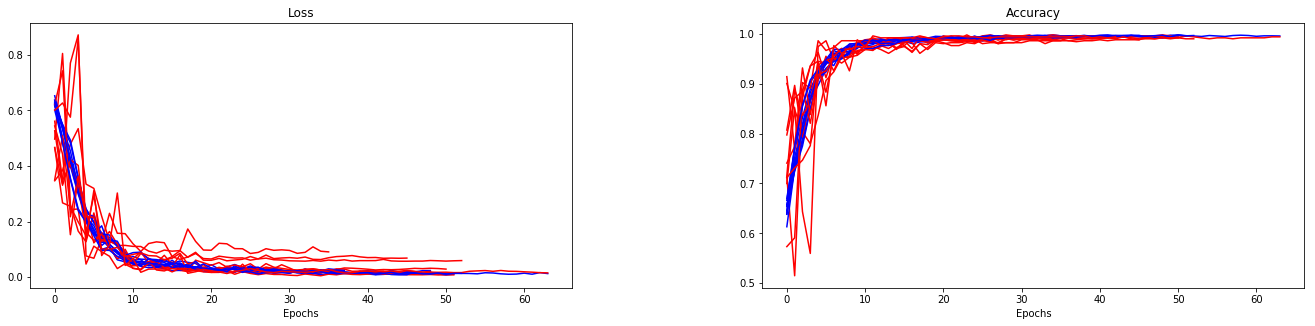

In [33]:
results = plt.figure()
for i in range(len(histories)):
    
    plt.subplot(1, 2, 1)
    plt.plot(histories[i]['loss'], color='b',label='Training set loss')
    plt.plot(histories[i]['val_loss'], color='r',label='Test set loss')
    plt.xlabel("Epochs")
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(histories[i]['acc'], color='b',label='Training set accuracy')
    plt.plot(histories[i]['val_acc'], color='r',label='Test set accuracy')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.subplots_adjust(top=0.92, bottom=0, left=-2, right=0.95, hspace=0, wspace=0.35)
    results.savefig('results_vm_2_lowervsplit.png', bbox_inches='tight')

For me, the models converged at approximately 20-40 epochs. The figure above shows the accuracy and loss convergence plots for the training (blue) and validation (red) sets. 

It seems that there are occasionally models that do fail to descend as far as the majority of others. This has been the case across several experiments. Future work could seek to stabilise this learning. 

## Counting misclassifications

In [34]:
# Count up the number of times each star was misclassfied
fp_counter = np.zeros_like(y_test)
fn_counter = np.zeros_like(y_test)

for i in range(len(fp_idxs)):
    for j in range(len(fp_idxs[i][0])):
        fp_counter[fp_idxs[i][0][j]] += 1 
fp_counter = fp_counter.transpose()[0]

for i in range(len(fn_idxs)):
    for j in range(len(fn_idxs[i][0])):
        fn_counter[fn_idxs[i][0][j]] += 1 
fn_counter = fn_counter.transpose()[0]


In [35]:
print(fp_counter)
print(fn_counter)

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

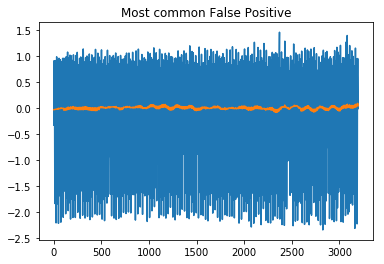

In [36]:
results = plt.figure()
plt.plot(x_test[fp_counter.argmax()])
plt.title("Most common False Positive")
results.savefig('star_fp.png', bbox_inches='tight')

Star 124 seems to be consistently misclassified by the models. 